Подключение необходимых библиотек

In [1]:
import math
import heapq
from typing import List, Tuple, Optional, Dict, Set
import numpy as np
import matplotlib.pyplot as plt

Решаем задачу: поиск кратчайшего пути между двумя локациями при условии, что есть препятсвия, заданные многоугольниками.

Класс "точка"

In [2]:
import math
from typing import List, Tuple

class Point:
    def __init__(self, x: float, y: float):
        """Конструктор"""
        self.x = x
        self.y = y

    def get(self) -> Tuple:
        """Получение координат"""
        return self.x, self.y

    # Базовые методы
    def __eq__(self, other) -> bool:
        """Проверка равенства точек"""
        return math.isclose(self.x, other.x) and math.isclose(self.y, other.y)

    def __hash__(self):
        """Хеширование"""
        return hash((round(self.x, 9), round(self.y, 9)))

    def __repr__(self):
        """ 'Официальное' представление точки"""
        return f"Point({self.x}, {self.y})"

    def __sub__(self, other):
        """Разность (векторов)"""
        return Point(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        """Сумма (векторов)"""
        return Point(self.x + other.x, self.y + other.y)

    # Геометрические операции
    def distance_to(self, other) -> float:
        """Евклидово расстояние до другой точки"""
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def distance_squared(self, other) -> float:
        """Квадрат расстояния (для оптимизации)"""
        return (self.x - other.x)**2 + (self.y - other.y)**2

    def dot(self, other) -> float:
        """Скалярное произведение"""
        return self.x * other.x + self.y * other.y

    def cross(self, other) -> float:
        """Векторное произведение"""
        return self.x * other.y - self.y * other.x

    def angle_to(self, other) -> float:
        """Угол к другой точке в радианах"""
        return math.atan2(other.y - self.y, other.x - self.x)

    def is_close(self, other, tolerance=1e-9) -> bool:
        """Проверка близости точек с допуском"""
        return self.distance_to(other) < tolerance

    def rotate_around(self, center, angle: float):
        """Поворот точки вокруг центра"""
        s = math.sin(angle)
        c = math.cos(angle)

        # Перенос в систему координат центра
        x_temp = self.x - center.x
        y_temp = self.y - center.y

        # Поворот
        x_new = x_temp * c - y_temp * s
        y_new = x_temp * s + y_temp * c

        # Обратный перенос
        return Point(x_new + center.x, y_new + center.y)

Класс "отрезок"

In [3]:
class Segment:
    def __init__(self, p1: Point, p2: Point):
        self.p1 = p1
        self.p2 = p2
        self.rvector = Point(p2.x - p1.x, p2.y - p1.y)

    def __repr__(self):
        return f"Segment({self.p1}, {self.p2})"

    def __contains__(self, point: Point) -> bool:
        return point == self.p1 or point == self.p2


    # Основные геометрические методы
    def length(self) -> float:
        """Длина отрезка"""
        return self.p1.distance_to(self.p2)

    def length_squared(self) -> float:
        """Квадрат длины отрезка"""
        return self.p1.distance_squared(self.p2)

    def direction_vector(self) -> Point:
        """Вектор направления отрезка"""
        return self.p2 - self.p1

    def midpoint(self) -> Point:
        """Середина отрезка"""
        return Point((self.p1.x + self.p2.x) / 2, (self.p1.y + self.p2.y) / 2)

    def contains_point(self, point: Point, include_endpoints=True) -> bool:
        """Проверка принадлежности точки отрезку"""
        if point.is_close(self.p1) or point.is_close(self.p2):
            return include_endpoints

        segment = Segment(self.p1, point)

        # Проверка коллинеарности
        cross_product = self.rvector.cross(segment.rvector)

        if abs(cross_product) > 1e-9: # sin угла > 0
            return False

        # Проверка что точка лежит между конечными точками
        dot_product = self.rvector.dot(segment.rvector)

        if dot_product < 0:  # угол 180
            return False

        if dot_product > self.length_squared():  # |segment| *|self| > |self|**2
            return False

        return True

    def intersects(self, other: 'Segment', exclude_endpoints=False) -> bool:
        """Проверка пересечения двух отрезков"""
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        
        a, b = self.p1, self.p2
        c, d = other.p1, other.p2
        
        # Если отрезки совпадают (являются одним и тем же ребром)
        if self == other:
            return False
        
        # Если концевые точки совпадают
        if a == c or a == d or b == c or b == d:
            return exclude_endpoints
        
        # Основная проверка пересечения
        intersect = ccw(a, c, d) != ccw(b, c, d) and ccw(a, b, c) != ccw(a, b, d)        
        return intersect


    def intersection_point(self, other) -> Point:
        """Точка пересечения двух отрезков (если существует)"""
        if not self.intersects(other):
            return None

        denominator = self.rvector.cross(other.rvector)

        if abs(denominator) < 1e-9:
            return None  # Параллельны или совпадают

        point = other.p1 - self.p1
        # Параметры t и u определяют положение точки на отрезке
        t = point.cross(other.rvector) / denominator
        u = -self.rvector.cross(point) / denominator

        if 0 <= t <= 1 and 0 <= u <= 1:
            x = self.p1.x + t * self.rvector.x
            y = self.p1.y + t * self.rvector.y
            return Point(x, y)

        return None

    def distance_to_point(self, point: Point) -> float:
        """Расстояние от точки до отрезка"""
        return self._point_segment_distance(point)

    def _point_segment_distance(self, point: Point) -> float:
        """Алгоритм вычисления расстояния от точки до отрезка"""
        l2 = self.length_squared()
        if l2 == 0:
            return point.distance_to(self.p1)

        # Проекция точки на линию отрезка
        t = max(0, min(1, (point - self.p1).dot(self.p2 - self.p1) / l2))
        projection = self.p1 + (self.p2 - self.p1) * t

        return point.distance_to(projection)
    
    def contains(self, point: Point) -> bool:
        """Проверка лежит ли точка на отрезке"""
        # Проверка коллинеарности
        cross = (point.y - self.p1.y) * (self.p2.x - self.p1.x) - \
                (point.x - self.p1.x) * (self.p2.y - self.p1.y)
        
        if abs(cross) > 1e-9:
            return False
        
        # Проверка что точка между конечными точками
        dot = (point.x - self.p1.x) * (self.p2.x - self.p1.x) + \
              (point.y - self.p1.y) * (self.p2.y - self.p1.y)
        
        squared_length = (self.p2.x - self.p1.x)**2 + (self.p2.y - self.p1.y)**2
        
        return 0 <= dot <= squared_length
    
    def find_ray_intersection(self, center: Point, angle: float) -> Point:
        """
        Находит точку пересечения луча с ребром
        """
        ray_dir = Point(math.cos(angle), math.sin(angle))
        edge_dir = self.p2 - self.p1
        
        denominator = ray_dir.cross(edge_dir)
        
        if abs(denominator) < 1e-9:
            return None
        
        t = ((self.p1 - center).cross(edge_dir)) / denominator
        u = ((self.p1 - center).cross(ray_dir)) / denominator
        
        if t >= 0 and 0 <= u <= 1:
            return Point(center.x + t * ray_dir.x, center.y + t * ray_dir.y)        
        return None
    
    def intersects_ray(self, center: Point, angle: float) -> bool:
        """
        Проверяет пересекает ли ребро луч, исходящий из центра под заданным углом
        """
        # Исключаем рёбра, содержащие центр
        if center in [self.p1, self.p2]:
            return False
            
        ray_length = 1000
        ray_point = Point(
            center.x + ray_length * math.cos(angle),
            center.y + ray_length * math.sin(angle)
        )
        ray_segment = Segment(center, ray_point)
        
        return self.intersects(ray_segment,exclude_endpoints=True)
    
    def is_edge_of_polygon(self, polygon: 'Polygon') -> bool:
        """Проверяет, является ли отрезок ребром полигона"""
        for i in range(len(polygon.points)):
            poly_edge = Segment(polygon.points[i], polygon.points[(i+1) % len(polygon.points)])
            if self == poly_edge:
                return True
        return False


(<matplotlib.patches.PathPatch at 0x7f9ace362710>,
 <matplotlib.lines.Line2D at 0x7f9ace38cf50>)

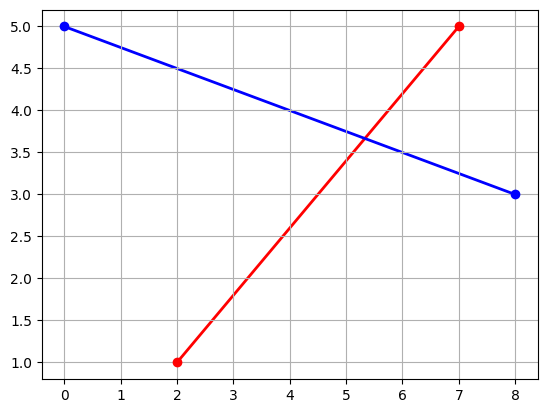

In [4]:
import shapely.geometry as geom
import shapely.plotting as splt
line1 = geom.LineString([[2,1], [7, 5]])
line2 = geom.LineString([[0,5], [8, 3]])
ax = plt.subplot()
ax.grid(visible=True);
splt.plot_line(line=line1, ax=ax, color='red')
splt.plot_line(line=line2, ax=ax, color='blue')


In [5]:
segm1 = Segment(Point(2,1), Point(7,5))
segm2 = Segment(Point(0, 5), Point(8, 3))
print(segm1, segm2)
segm1.intersects(segm2)

Segment(Point(2, 1), Point(7, 5)) Segment(Point(0, 5), Point(8, 3))


True

In [6]:
segm1.intersection_point(segm2)

Point(5.333333333333333, 3.6666666666666665)

In [7]:
class Edge (Segment):
    def __init(self, p1: Point, p2: Point):
        super.__init(p1, p2)
        self.weight = p1.distance_to(p2)

Класс "многоугольник"

In [8]:
class Polygon:
    def __init__(self, points: List[Point]):
        # вершины
        self.points = points
        # ребра
        self.edges = []
        x_min, y_min, x_max, y_max = 10 ** 9, 10 ** 9, -10 ** 9, -10 ** 9
        for i in range(len(points)):
            self.edges.append(Segment(points[i], points[(i+1) % len(points)]))
            x_max = max(x_max, points[i].x)
            y_max = max(y_max, points[i].y)
            x_min = min(x_min, points[i].x)
            y_min = min(y_min, points[i].y)
        self.bbox = [x_min, y_min, x_max, y_max]

    def __repr__(self):
        return f"Polygon{self.points}"

    def contains_point(self, point: Point) -> bool:
        """
        Алгоритм Ray Casting для проверки точки внутри многоугольника
        Возвращает True если точка внутри, False если снаружи
        """
        px, py = point.x, point.y

        # Проверка на совпадение с вершиной
        for vertex in self.points:
            if vertex == point:
                return True

        intersection_count = 0

        for edge in self.edges:
            x1, y1 = edge.p1.get()
            x2, y2 = edge.p2.get()

            # Пропускаем горизонтальные ребра
            if abs(y1 - y2) < 1e-9:
                continue

            # Проверка что ребро пересекает горизонтальный луч из точки
            if (y1 > py and y2 <= py) or (y2 > py and y1 <= py):
                # Вычисление X-координаты пересечения
                x_intersect = x1 + (py - y1) * (x2 - x1) / (y2 - y1)

                # Если пересечение справа от точки
                if px < x_intersect:
                    intersection_count += 1

        return intersection_count % 2 == 1

    def intersects_segment(self, segment: Segment) -> bool:
        """Проверка пересечения отрезка с многоугольником"""
        # Быстрая проверка по ограничивающему прямоугольнику
        seg_bbox = (
            min(segment.p1.x, segment.p2.x),
            min(segment.p1.y, segment.p2.y),
            max(segment.p1.x, segment.p2.x),
            max(segment.p1.y, segment.p2.y)
        )

        if not self._bbox_intersects(seg_bbox):
            return False

        # Проверка пересечения с ребрами
        for edge in self.edges:
            if segment.intersects(edge):
                return True

        # Проверка что отрезок полностью внутри полигона
        if self.contains_point(segment.p1) and self.contains_point(segment.p2):
            return True

        return False

    def _bbox_intersects(self, other_bbox: Tuple[float, float, float, float]) -> bool:
        """Проверка пересечения ограничивающих прямоугольников"""
        x_min1, y_min1, x_max1, y_max1 = self.bbox
        x_min2, y_min2, x_max2, y_max2 = other_bbox

        return not (x_max1 < x_min2 or x_min1 > x_max2 or
                   y_max1 < y_min2 or y_min1 > y_max2)
    
    def is_point_on_boundary(self, point: Point) -> bool:
        """Проверяет, лежит ли точка на границе полигона"""
        for edge in self.edges:
            if edge.contains(point):
                return True
        return False 
    
    def has_inside(self, point: Point) -> bool:
        """Проверка точки внутри полигона (ray casting)"""
        n = len(self.points)
        inside = False
        
        p1 = self.points[0]
        for i in range(1, n + 1):
            p2 = self.points[i % n]
            
            # Если точка лежит на границе - не считаем её внутри
            if Segment(p1, p2).contains(point):
                return False
            
            if (p1.y > point.y) != (p2.y > point.y):
                if point.x < (p2.x - p1.x) * (point.y - p1.y) / (p2.y - p1.y) + p1.x:
                    inside = not inside
            p1 = p2        
        return inside

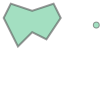

In [9]:
import shapely.geometry as geom
vertices = [[2,0], [4,2], [6,1], [8,4], [7,6],  [4,5], [1,6], [0,4]]
_polygon = geom.Polygon(vertices)
_point = geom.Point(13,3)
geom.collection.GeometryCollection([_polygon, _point])

In [10]:
polygon = Polygon([Point(x,y) for x,y in vertices])
point = Point(13, 3)
polygon.contains_point(point)

False

In [11]:
polygon.bbox

[0, 0, 8, 6]

Граф видимости

In [12]:
class VisibilityGraph:
    def __init__(self, obstacles: List[Polygon]):
        self.obstacles = obstacles
        self.all_edges = self._get_all_edges()
    
    def _get_all_edges(self) -> List[Segment]:
        """Получить все рёбра всех препятствий"""
        edges = []
        for poly in self.obstacles:
            edges.extend(poly.edges)
        return edges
    
    def _get_all_vertices(self) -> List[Point]:
        """Получить все вершины препятствий"""
        vertices = []
        for poly in self.obstacles:
            vertices.extend(poly.points)
        return vertices 
    
    def _is_segment_polygon_edge(self, segment: Segment) -> bool:
        """Проверяет, является ли отрезок ребром какого-либо препятствия"""
        for poly in self.obstacles:
            if segment.is_edge_of_polygon(poly):
                return True
        return False    
    
    
    def _is_visible_direct(self, center: Point, target: Point) -> bool:
        """Прямая проверка видимости между двумя точками с учётом рёбер препятствий"""
        if center == target:
            return True
        
        test_segment = Segment(center, target)
        
        # Если отрезок является ребром препятствия - он всегда видим
        if self._is_segment_polygon_edge(test_segment):
            return True
        
        # Проверка пересечения с рёбрами препятствий
        for edge in self.all_edges:
            # Пропускаем рёбра, содержащие концевые точки (кроме случая, когда это ребро препятствия)
            if (center in [edge.p1, edge.p2] or target in [edge.p1, edge.p2]):
                # Если обе точки лежат на одном препятствии, проверяем не является ли это ребром
                if self._are_points_on_same_polygon_edge(center, target):
                    return True
                continue
            
            if edge.intersects(test_segment):
                return False
        
        # Проверка что точки не внутри препятствий (но могут быть на границе)
        for poly in self.obstacles:
            if poly.has_inside(center):
                return False
            if poly.has_inside(target):
                return False 
            
            center_on = poly.is_point_on_boundary(center)
            target_on = poly.is_point_on_boundary(target)
            if center_on and target_on:
                return False
        
        return True
    
    def _are_points_on_same_polygon_edge(self, p1: Point, p2: Point) -> bool:
        """Проверяет, лежат ли две точки на одном ребре какого-либо препятствия"""
        for poly in self.obstacles:
            for edge in poly.edges:
                if edge.contains(p1) and edge.contains(p2):
                    return True
        return False
    
    

    def build_rotation_sweep(self, start: Point, goal: Point) -> Dict[Point, List[Tuple[Point, float]]]:
        """
        Построение графа видимости алгоритмом Rotation Sweep
        с учётом рёбер препятствий
        """
        vertices = self._get_all_vertices()
        all_points = vertices + [start, goal]
        graph = {point: [] for point in all_points}
        
        # Шаг 1-7 для каждой точки
        for center_point in all_points:
            # ШАГ 1: Подготовка данных
            other_points = [p for p in all_points if p != center_point]
            
            # ШАГ 2: Сортировка по углу
            other_points.sort(key=lambda p: (
                center_point.angle_to(p),  # Основная сортировка по углу
                center_point.distance_to(p)  # Вторичная по расстоянию
            ))
            
            # ШАГ 3: Инициализация активных рёбер
            active_edges = self._initialize_active_edges(center_point)
                                    
            # ШАГ 4-6: Вращение луча и обработка событий
            visible_count = 0
            for target_point in other_points:
                # ШАГ 5: Проверка видимости с учётом активных рёбер
                is_visible = self._check_visibility_with_active_edges(
                    center_point, target_point, active_edges
                )
                
                if is_visible:
                    distance = center_point.distance_to(target_point)
                    graph[center_point].append((target_point, distance))
                    visible_count += 1 
                
                # ШАГ 6: Обновление активных рёбер
                self._update_active_edges(center_point, target_point, active_edges)
         
        return graph

    def _initialize_active_edges(self, center: Point) -> Set[Segment]:
        """
        ШАГ 3: Инициализация активных рёбер
        """
        active_edges = set()
        
        # Начальный луч направлен вправо (угол 0)
        for edge in self.all_edges:
            if edge.intersects_ray(center, 0):
                active_edges.add(edge)
        
        return active_edges
    

    def _check_visibility_with_active_edges(self, center: Point, target: Point, 
                                          active_edges: Set[Segment]) -> bool:
        """
        ШАГ 5: Проверка видимости с учётом активных рёбер
        """
        if center == target:
            return True
        
        test_segment = Segment(center, target)
        
        # Если отрезок является ребром препятствия - всегда видим
        if self._is_segment_polygon_edge(test_segment):
            return True
        
        # Если есть активные рёбра, проверяем не закрывают ли они цель
        if active_edges:
            closest_blocking_edge = VisibilityGraph.find_closest_blocking_edge(
                center, target, active_edges
            )
            
            if closest_blocking_edge:
                if self._is_target_blocked(center, target, closest_blocking_edge):
                    return False
        
        # Финальная проверка прямой видимости
        return self._is_visible_direct(center, target)
    @staticmethod
    def find_closest_blocking_edge(center: Point, target: Point, 
                                  active_edges: Set[Segment]) -> Segment:
        """
        Находит ближайшее активное ребро, которое может блокировать видимость
        """
        target_angle = center.angle_to(target)
        min_distance = float('inf')
        closest_edge = None
        
        for edge in active_edges:
            # Исключаем рёбра, содержащие целевую точку
            if target in [edge.p1, edge.p2]:
                continue
                
            intersection = edge.find_ray_intersection(center, target_angle)
            if intersection:
                distance = center.distance_to(intersection)
                if distance < min_distance and distance < center.distance_to(target):
                    min_distance = distance
                    closest_edge = edge
        
        return closest_edge    

    def _is_target_blocked(self, center: Point, target: Point, blocking_edge: Segment) -> bool:
        """
        Проверяет, закрывает ли активное ребро цель
        """
        target_angle = center.angle_to(target)
        intersection = blocking_edge.find_ray_intersection(center, target_angle)
        
        if not intersection:
            return False
        
        return center.distance_to(intersection) < center.distance_to(target)

    def _update_active_edges(self, center: Point, current_target: Point, 
                           active_edges: Set[Segment]):
        """
        ШАГ 6: Обновление активных рёбер при достижении новой точки
        """
        current_angle = center.angle_to(current_target)
        
        # Удаляем рёбра, которые больше не пересекают луч
        edges_to_remove = set()
        for edge in active_edges:
            if not edge.intersects_ray(center, current_angle):
                edges_to_remove.add(edge)
        active_edges -= edges_to_remove
        
        # Добавляем рёбра, которые начинают пересекать луч
        for edge in self.all_edges:
            if edge not in active_edges and \
               edge.intersects_ray(center, current_angle):
                active_edges.add(edge)


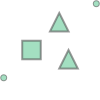

In [13]:
# Условия задачи
task = geom.collection.GeometryCollection([
        geom.Point(0, 0),
        geom.Point(10, 8),
        geom.Polygon([geom.Point(2, 2), geom.Point(4, 2), geom.Point(4, 4), geom.Point(2, 4)]),  # Квадрат
        geom.Polygon([geom.Point(6, 1), geom.Point(8, 1), geom.Point(7, 3)]),  # Треугольник
        geom.Polygon([geom.Point(5, 5), geom.Point(7, 5), geom.Point(6, 7)]),  # Еще треугольник
])
task

In [14]:
obstacles = [
        Polygon([Point(2, 2), Point(4, 2), Point(4, 4), Point(2, 4)]),  # Квадрат
        Polygon([Point(6, 1), Point(8, 1), Point(7, 3)]),  # Треугольник
        Polygon([Point(5, 5), Point(7, 5), Point(6, 7)]),  # Еще треугольник
    ]
start = Point(0, 0)
goal = Point(10, 8)

In [15]:
graph = VisibilityGraph(obstacles)
graph_ = graph.build_rotation_sweep(start, goal)

In [19]:
edges_ = []
for point in graph_:
  for target, w in graph_[point]:
    edges_.append(geom.LineString([geom.Point(point.x, point.y),
                                   geom.Point(target.x, target.y)]))
len(edges_)

77

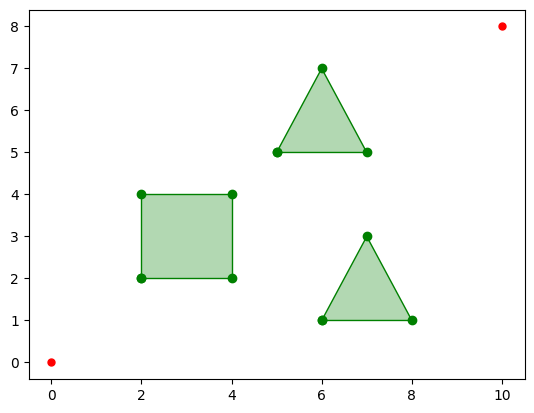

In [31]:
ax = plt.subplot()
for geom_obj in task.geoms:
  if geom_obj.geom_type == 'Point':
    ax.plot(geom_obj.x, geom_obj.y, 'ro', markersize=5)
  else: splt.plot_polygon(polygon=geom_obj, ax=ax, color='green')
#for edge in edges_:
#  splt.plot_line(line=edge, ax=ax, color='blue', linewidth=0.5)
plt.show()

In [26]:
def a_star(start: Point, goal: Point, graph: Dict[Point, List[Tuple[Point, float]]]) -> List[Point]:
    """Алгоритм A* для поиска кратчайшего пути"""

    def heuristic(point: Point) -> float:
        """Эвристическая функция - евклидово расстояние до цели"""
        return math.sqrt((goal.x - point.x)**2 + (goal.y - point.y)**2)

    # Инициализация
    pq = []
    heapq.heappush(pq, (0, start))

    prev: Dict[Point, Point] = {}
    g_score: Dict[Point, float] = {start: 0}
    f_score: Dict[Point, float] = {start: heuristic(start)}

    iterations = 0   

    while pq:
        iterations += 1
        _, current = heapq.heappop(pq)
        if current == goal:            
            # Восстановление пути
            path = [current]
            while current in prev:
                current = prev[current]
                path.append(current)
            return path[::-1]

        for neighbor, distance in graph[current]:
            g = g_score[current] + distance

            if neighbor not in g_score or g < g_score[neighbor]:
                prev[neighbor] = current
                g_score[neighbor] = g
                f_score[neighbor] = g + heuristic(neighbor)
                heapq.heappush(pq, (f_score[neighbor], neighbor))

    print("Путь не найден")
    return []

In [27]:
path = a_star(start, goal, graph_)
path

[Point(0, 0), Point(4, 2), Point(7, 5), Point(10, 8)]

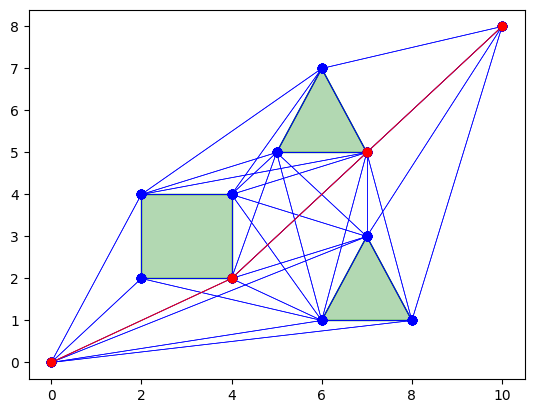

In [29]:
ax = plt.subplot()
for geom_obj in task.geoms:
  if geom_obj.geom_type == 'Point':
    ax.plot(geom_obj.x, geom_obj.y, 'ro', markersize=1)
  else: splt.plot_polygon(polygon=geom_obj, ax=ax, color='green')
for edge in edges_:
  splt.plot_line(line=edge, ax=ax, color='blue', linewidth=0.5)
for i in range(len(path) - 1):
  line = geom.LineString([[path[i].x, path[i].y],[path[i + 1].x, path[i + 1].y]])
  splt.plot_line(line=line, ax=ax, color='red', linewidth=0.7)
plt.show()

Оптимальный подход: Алгоритм с Rotational Sweep

- Для каждой вершины сортируем другие вершины по углу
- Используем вращающийся луч для эффективной проверки видимости

Сложность: O(n² log n)